In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from pycaret.classification import ClassificationExperiment
from pycaret.classification import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from datetime import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet['pet_size'].unique()

array(['small', 'large', 'extra_small', 'medium', 'extra_large'],
      dtype=object)

In [4]:
datasheet = datasheet.drop([
    'vendor_id', 
    'rating',
    'sales',
    'price',
    'country',
    're_buy',
    'VAP'
], axis=1)
datasheet.head()

,product_category,pet_size,pet_type
product_id,,,
5040,Equipment,small,fish
4567,Toys,small,cat
4237,Toys,small,hamster
4364,Snack,large,dog
4184,Supplements,large,dog


In [5]:
datasheet['pet_type'].unique()

array(['fish', 'cat', 'hamster', 'dog', 'bird', 'rabbit'], dtype=object)

### Plotting for analysis

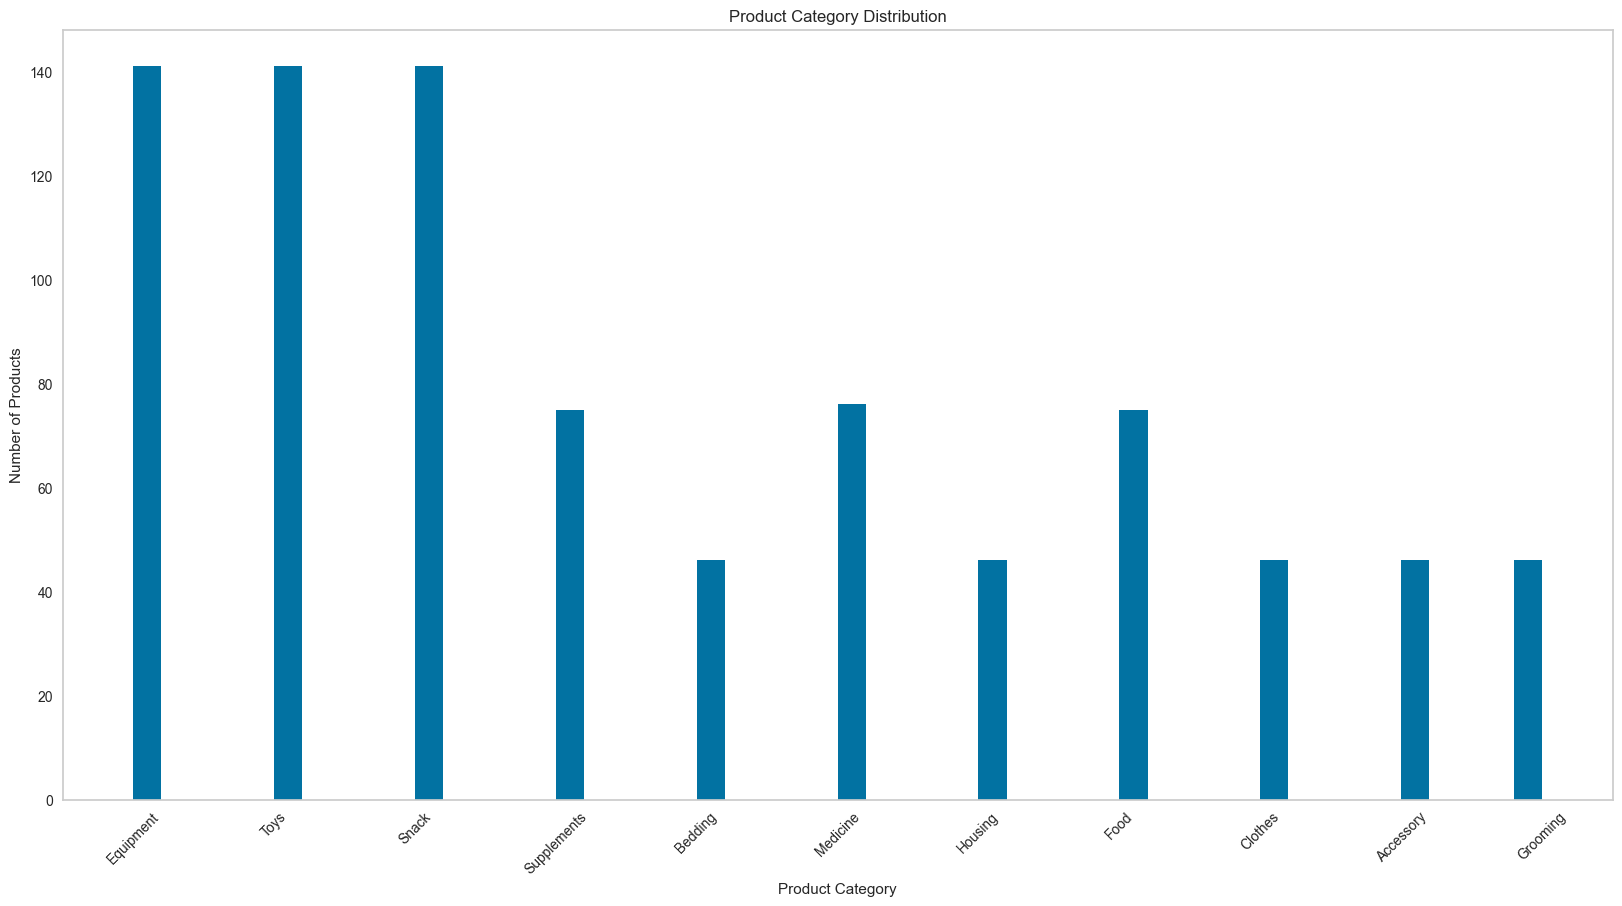

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

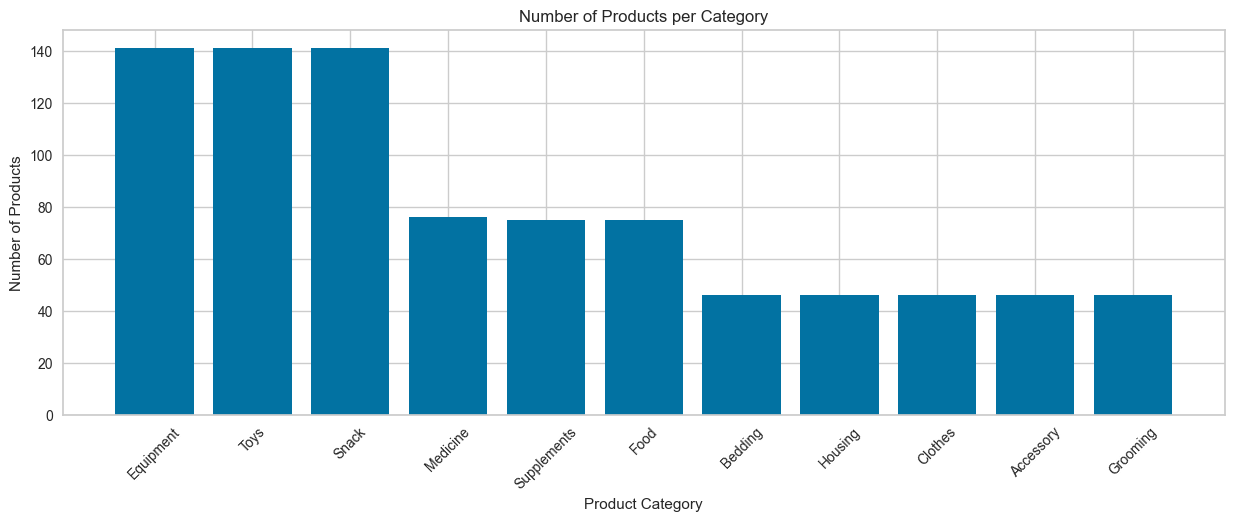

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

# Pre-processing

### Product Category Pre-processing

In [8]:
product_category = datasheet['product_category'].unique()
grouped_category_target = {
    'Lifestyle' : ['Equipment', 'Housing', 'Bedding'],
    'Food' : ['Food', 'Snack'],
    'Grooming' : ['Grooming'],
    'Medicine' : ['Medicine', 'Supplements'],
    'Clothes' : ['Clothes', 'Accessory'],
    'Toys' : ['Toys'],
}

def get_category(category):
    for key, value in grouped_category_target.items():
        if category in value:   return key
    print(f'Unknown category: {category}')
    return 'Others'

datasheet['product_category'] = datasheet['product_category'].apply(get_category)
print(datasheet['product_category'].unique())

['Lifestyle' 'Toys' 'Food' 'Medicine' 'Clothes' 'Grooming']


In [9]:
datasheet.head(10)

,product_category,pet_size,pet_type
product_id,,,
5040,Lifestyle,small,fish
4567,Toys,small,cat
4237,Toys,small,hamster
4364,Food,large,dog
4184,Medicine,large,dog
4609,Lifestyle,large,cat
4380,Toys,extra_small,dog
4389,Lifestyle,large,cat
4697,Medicine,small,cat


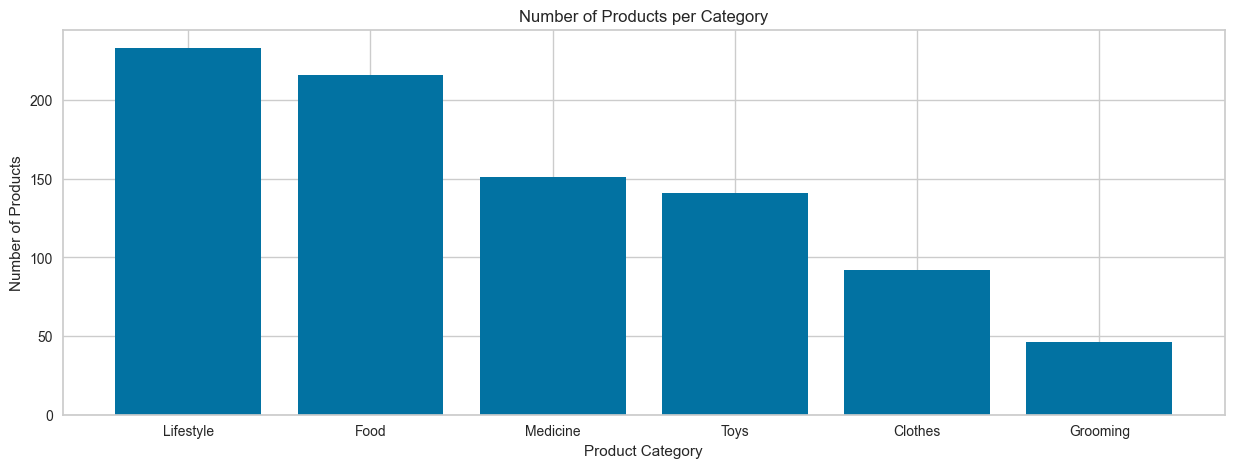

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index)
plt.grid(True)
plt.show()

In [11]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

datasheet['product_category'] = product_category

[Lifestyle]	->	[0]
[Toys]	->	[1]
[Food]	->	[2]
[Medicine]	->	[3]
[Clothes]	->	[4]
[Grooming]	->	[5]


In [12]:
# Remove pet type except dog, cat
datasheet['pet_type'] = datasheet['pet_type'].apply(lambda x: x if x in ['dog', 'cat'] else np.nan)
datasheet = datasheet.dropna()

print(datasheet['pet_type'].unique())

['cat' 'dog']


### Pet Type Pre-processing

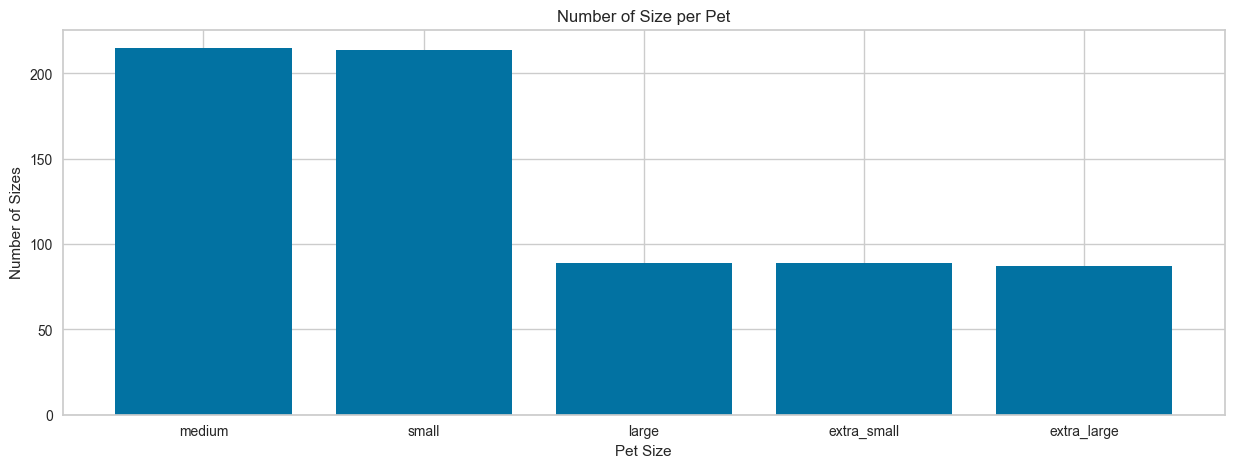

In [13]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['pet_size'].value_counts())), height=datasheet['pet_size'].value_counts())
plt.xlabel('Pet Size')
plt.ylabel('Number of Sizes')
plt.title('Number of Size per Pet')
plt.xticks(range(len(datasheet['pet_size'].value_counts())), datasheet['pet_size'].value_counts().index)
plt.grid(True)
plt.show()

In [14]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])

datasheet['pet_type'] = pet_type

[0]	->	cat
[1]	->	dog


### Pet Size Pre-processing

In [15]:
org_pet_size = datasheet['pet_size'].to_list()
pet_size_uni = datasheet['pet_size'].unique()
pet_size_uni_code = [i for i in range(len(pet_size_uni))]
for i in range(len(pet_size_uni)):  print(f"{org_pet_size[i]}\t->\t{pet_size_uni_code[i]}")

pet_size = []
for i in range(len(org_pet_size)):
    for j in range(len(pet_size_uni)):
        if org_pet_size[i] == pet_size_uni[j]:
            pet_size.append(pet_size_uni_code[j])

datasheet['pet_size'] = pet_size

small	->	0
large	->	1
large	->	2
large	->	3
extra_small	->	4


### Check for validate

In [16]:
datasheet.to_csv('./data/processed_dataset.csv')

# Train, Test(Validation) Split

In [17]:
print(datasheet.columns)
target = "product_category"

Index(['product_category', 'pet_size', 'pet_type'], dtype='object')


In [18]:
y_data = datasheet[target].to_numpy()
X_data = datasheet.drop([target], axis=1).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (694, 2)
y_data shape: (694,)


In [19]:
fig = px.scatter_3d(
    datasheet,
    x='pet_size',
    y='pet_type',
    z='product_category',
    color='product_category',
    opacity=0.7
)

fig.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, shuffle=True, stratify=y_data)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (485, 2)
y_train: (485,)
X_test: (209, 2)
y_test: (209,)


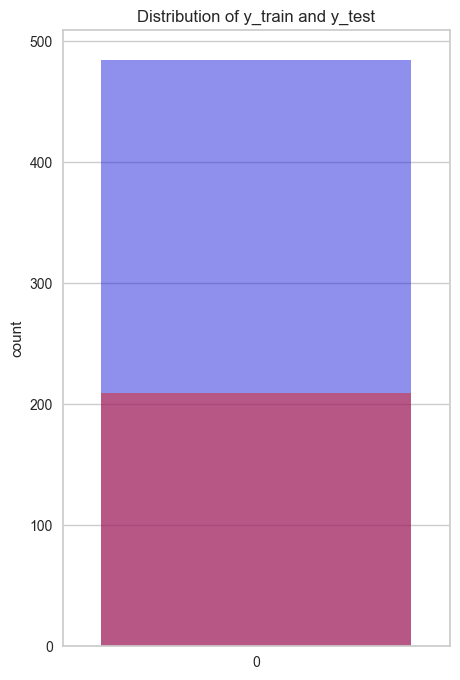

In [21]:
# X_train, y_train, X_test, y_test distribution plot
plt.figure(figsize=(5, 8))
plt.title('Distribution of y_train and y_test')
sns.countplot(y_train, color='blue', label='train', alpha=0.5)
sns.countplot(y_test, color='red', label='test', alpha=0.5)
plt.show()

In [22]:
datasheet.head(5)

,product_category,pet_size,pet_type
product_id,,,
4567,1,0,0
4364,2,1,1
4184,3,1,1
4609,0,1,0
4380,1,2,1


In [67]:
for idx in range(len(X_train)):
    print(f"X_train[{idx}]: {X_train[idx][0]}, {X_train[idx][1]} -> {y_train[idx]}")

X_train[0]: 0, 1 -> 0
X_train[1]: 3, 0 -> 1
X_train[2]: 3, 0 -> 0
X_train[3]: 3, 0 -> 2
X_train[4]: 3, 0 -> 1
X_train[5]: 4, 0 -> 0
X_train[6]: 3, 0 -> 3
X_train[7]: 0, 0 -> 5
X_train[8]: 0, 1 -> 3
X_train[9]: 3, 0 -> 1
X_train[10]: 0, 1 -> 2
X_train[11]: 1, 1 -> 5
X_train[12]: 4, 1 -> 1
X_train[13]: 0, 0 -> 4
X_train[14]: 0, 1 -> 1
X_train[15]: 4, 0 -> 4
X_train[16]: 3, 0 -> 3
X_train[17]: 0, 1 -> 2
X_train[18]: 0, 1 -> 0
X_train[19]: 0, 1 -> 1
X_train[20]: 1, 1 -> 0
X_train[21]: 3, 1 -> 3
X_train[22]: 3, 0 -> 0
X_train[23]: 0, 1 -> 2
X_train[24]: 4, 1 -> 2
X_train[25]: 3, 0 -> 3
X_train[26]: 0, 1 -> 1
X_train[27]: 1, 1 -> 5
X_train[28]: 0, 0 -> 3
X_train[29]: 0, 1 -> 2
X_train[30]: 3, 0 -> 2
X_train[31]: 4, 0 -> 2
X_train[32]: 3, 0 -> 3
X_train[33]: 2, 0 -> 4
X_train[34]: 0, 1 -> 3
X_train[35]: 4, 0 -> 2
X_train[36]: 3, 0 -> 2
X_train[37]: 3, 0 -> 3
X_train[38]: 3, 1 -> 0
X_train[39]: 3, 0 -> 1
X_train[40]: 4, 1 -> 4
X_train[41]: 0, 1 -> 3
X_train[42]: 1, 1 -> 3
X_train[43]: 2, 1 -> 

# autoML

In [23]:
s = setup(datasheet, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(694, 3)"
4,Transformed data shape,"(694, 3)"
5,Transformed train set shape,"(485, 3)"
6,Transformed test set shape,"(209, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [24]:
exp = ClassificationExperiment()
exp.setup(data=datasheet, target=target)

,Description,Value
0,Session id,3523
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(694, 3)"
4,Transformed data shape,"(694, 3)"
5,Transformed train set shape,"(485, 3)"
6,Transformed test set shape,"(209, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [25]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.2557,0.5000,0.2557,0.0655,0.1043,0.0000,0.0000,0.0100
dt,Decision Tree Classifier,0.2393,0.4914,0.2393,0.1834,0.1779,-0.0031,-0.0059,0.0110
et,Extra Trees Classifier,0.2393,0.4914,0.2393,0.1834,0.1779,-0.0031,-0.0059,0.0290
lightgbm,Light Gradient Boosting Machine,0.2372,0.4919,0.2372,0.1870,0.1795,-0.0040,-0.0055,0.0170
lr,Logistic Regression,0.2268,0.4480,0.2268,0.1147,0.1415,-0.0296,-0.0306,0.2590
ridge,Ridge Classifier,0.2247,0.0000,0.2247,0.1145,0.1430,-0.0324,-0.0361,0.0090
lda,Linear Discriminant Analysis,0.2247,0.4489,0.2247,0.1145,0.1430,-0.0324,-0.0361,0.0110
nb,Naive Bayes,0.2185,0.4429,0.2185,0.1316,0.1368,-0.0413,-0.0415,0.0100
gbc,Gradient Boosting Classifier,0.2166,0.4905,0.2166,0.1665,0.1643,-0.0249,-0.0280,0.0600
rf,Random Forest Classifier,0.2144,0.4901,0.2144,0.1705,0.1675,-0.0237,-0.0266,0.0420


# Random Forest Classification

In [26]:
classifier = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, verbose=1, n_jobs=-1)
classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=1, warm_start=False)

In [27]:
y_pred = classifier.predict(X_test)
mse_loss = mean_squared_error(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.22      0.22        54
           1       0.00      0.00      0.00        31
           2       0.29      0.64      0.40        50
           3       0.11      0.07      0.09        41
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        11

    accuracy                           0.22       209
   macro avg       0.10      0.16      0.12       209
weighted avg       0.15      0.22      0.17       209



In [29]:
y_pred_train = classifier.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.27      0.26      0.26       124
           1       0.00      0.00      0.00        71
           2       0.28      0.67      0.40       117
           3       0.27      0.18      0.22        94
           4       0.28      0.15      0.20        53
           5       0.00      0.00      0.00        26

    accuracy                           0.28       485
   macro avg       0.18      0.21      0.18       485
weighted avg       0.22      0.28      0.23       485



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


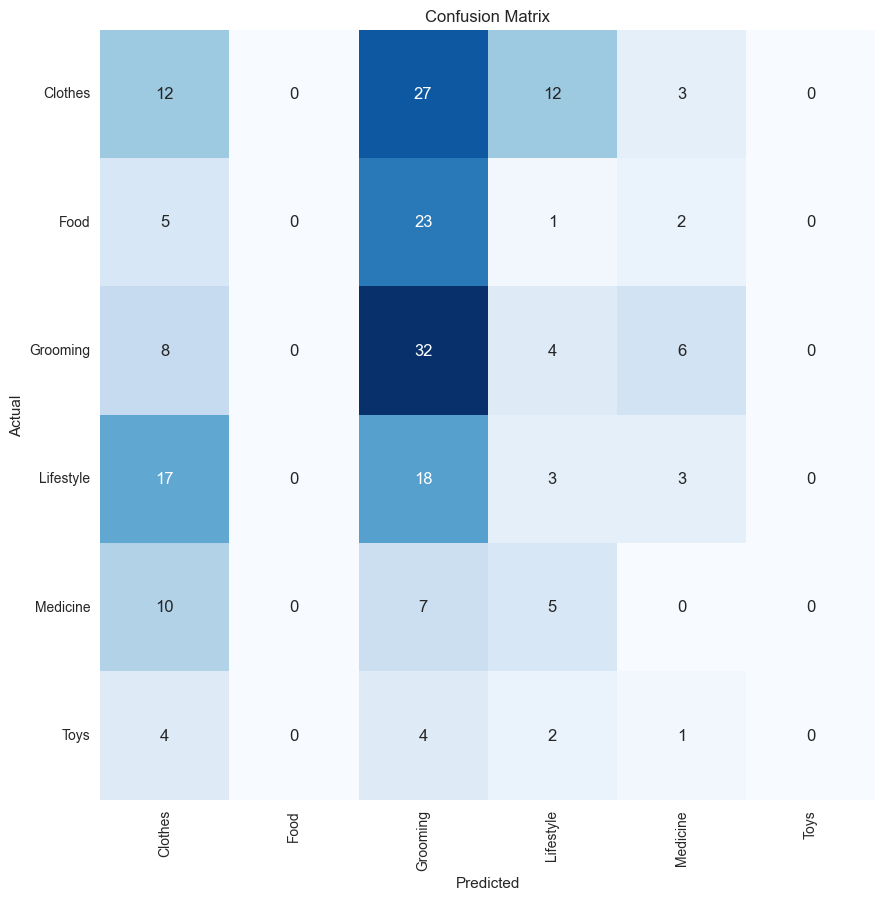

In [30]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

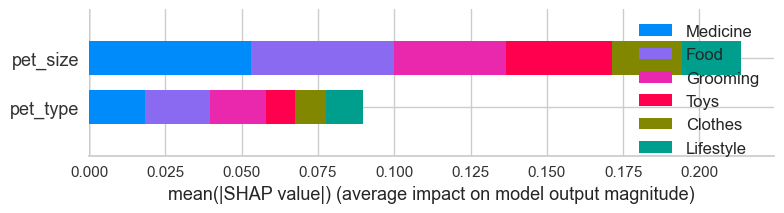

In [31]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Decision Tree Classification

In [53]:
classifier = DecisionTreeClassifier(
    # ccp_alpha=0.0125,
    # max_depth=15,
    # class_weight=None, 
    # criterion='entropy',
)

In [54]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)
print(f"Model score: {classifier.score(X_test, y_test)}")

MSE Loss:  4.507177033492823
Model score: 0.23923444976076555


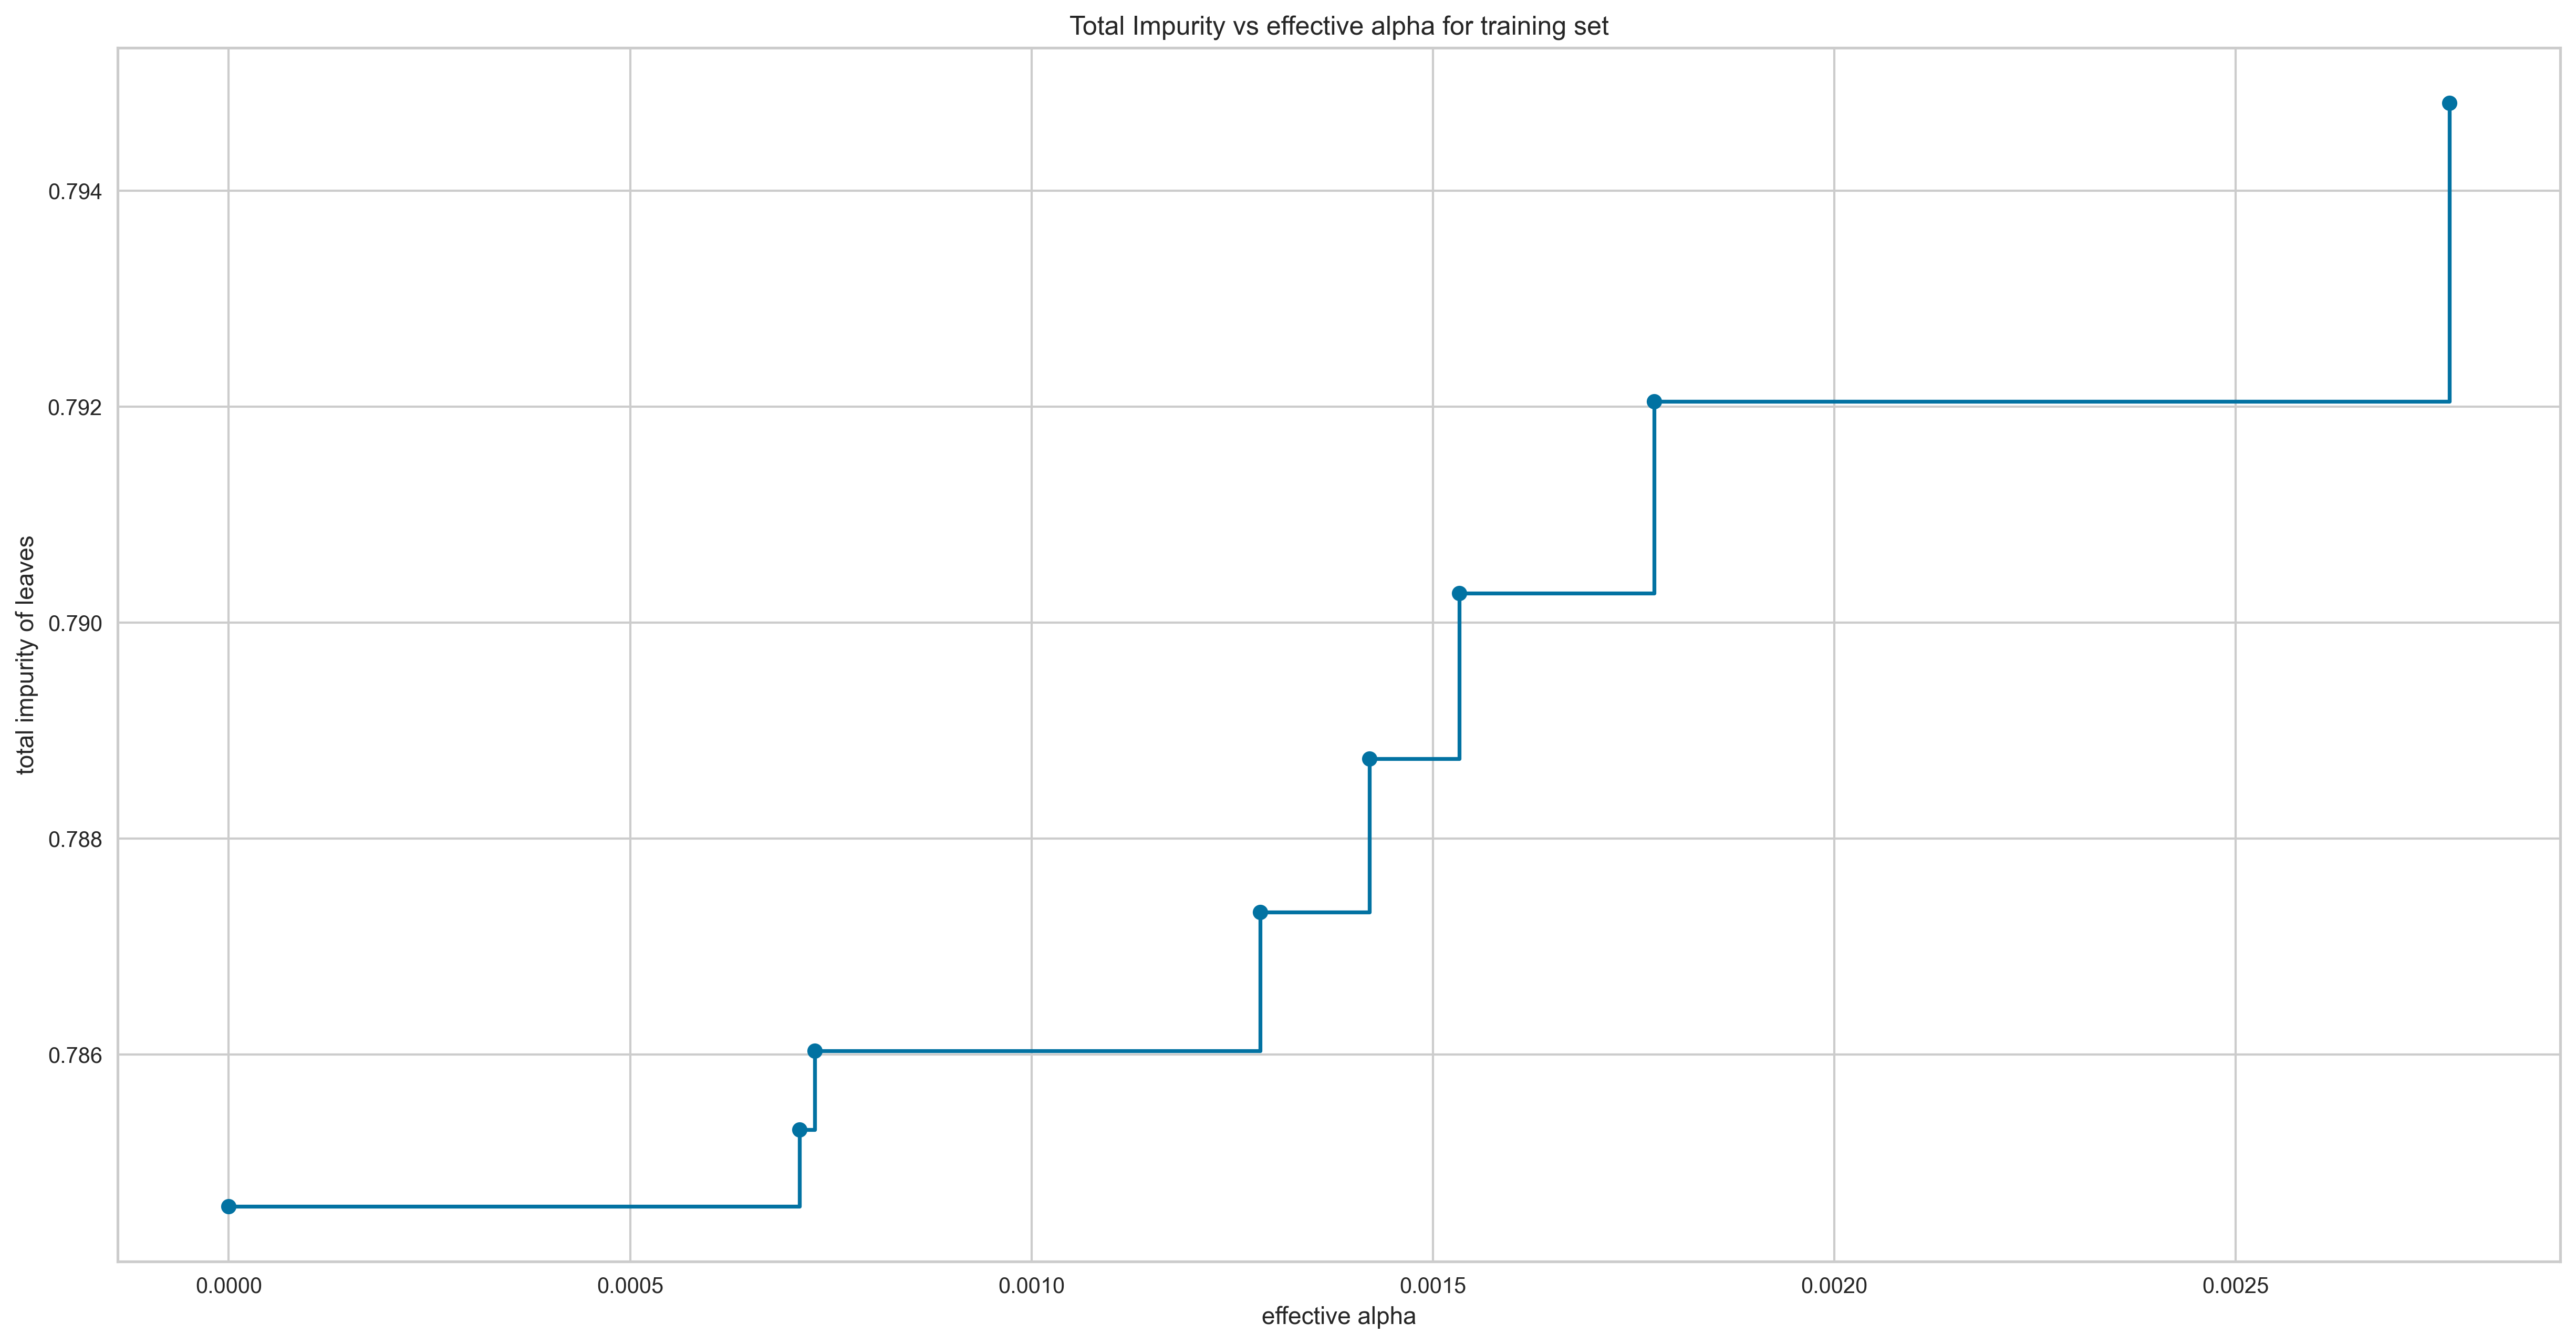

In [55]:
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs effective alpha for training set')
plt.show()

In [56]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.003906522999726603


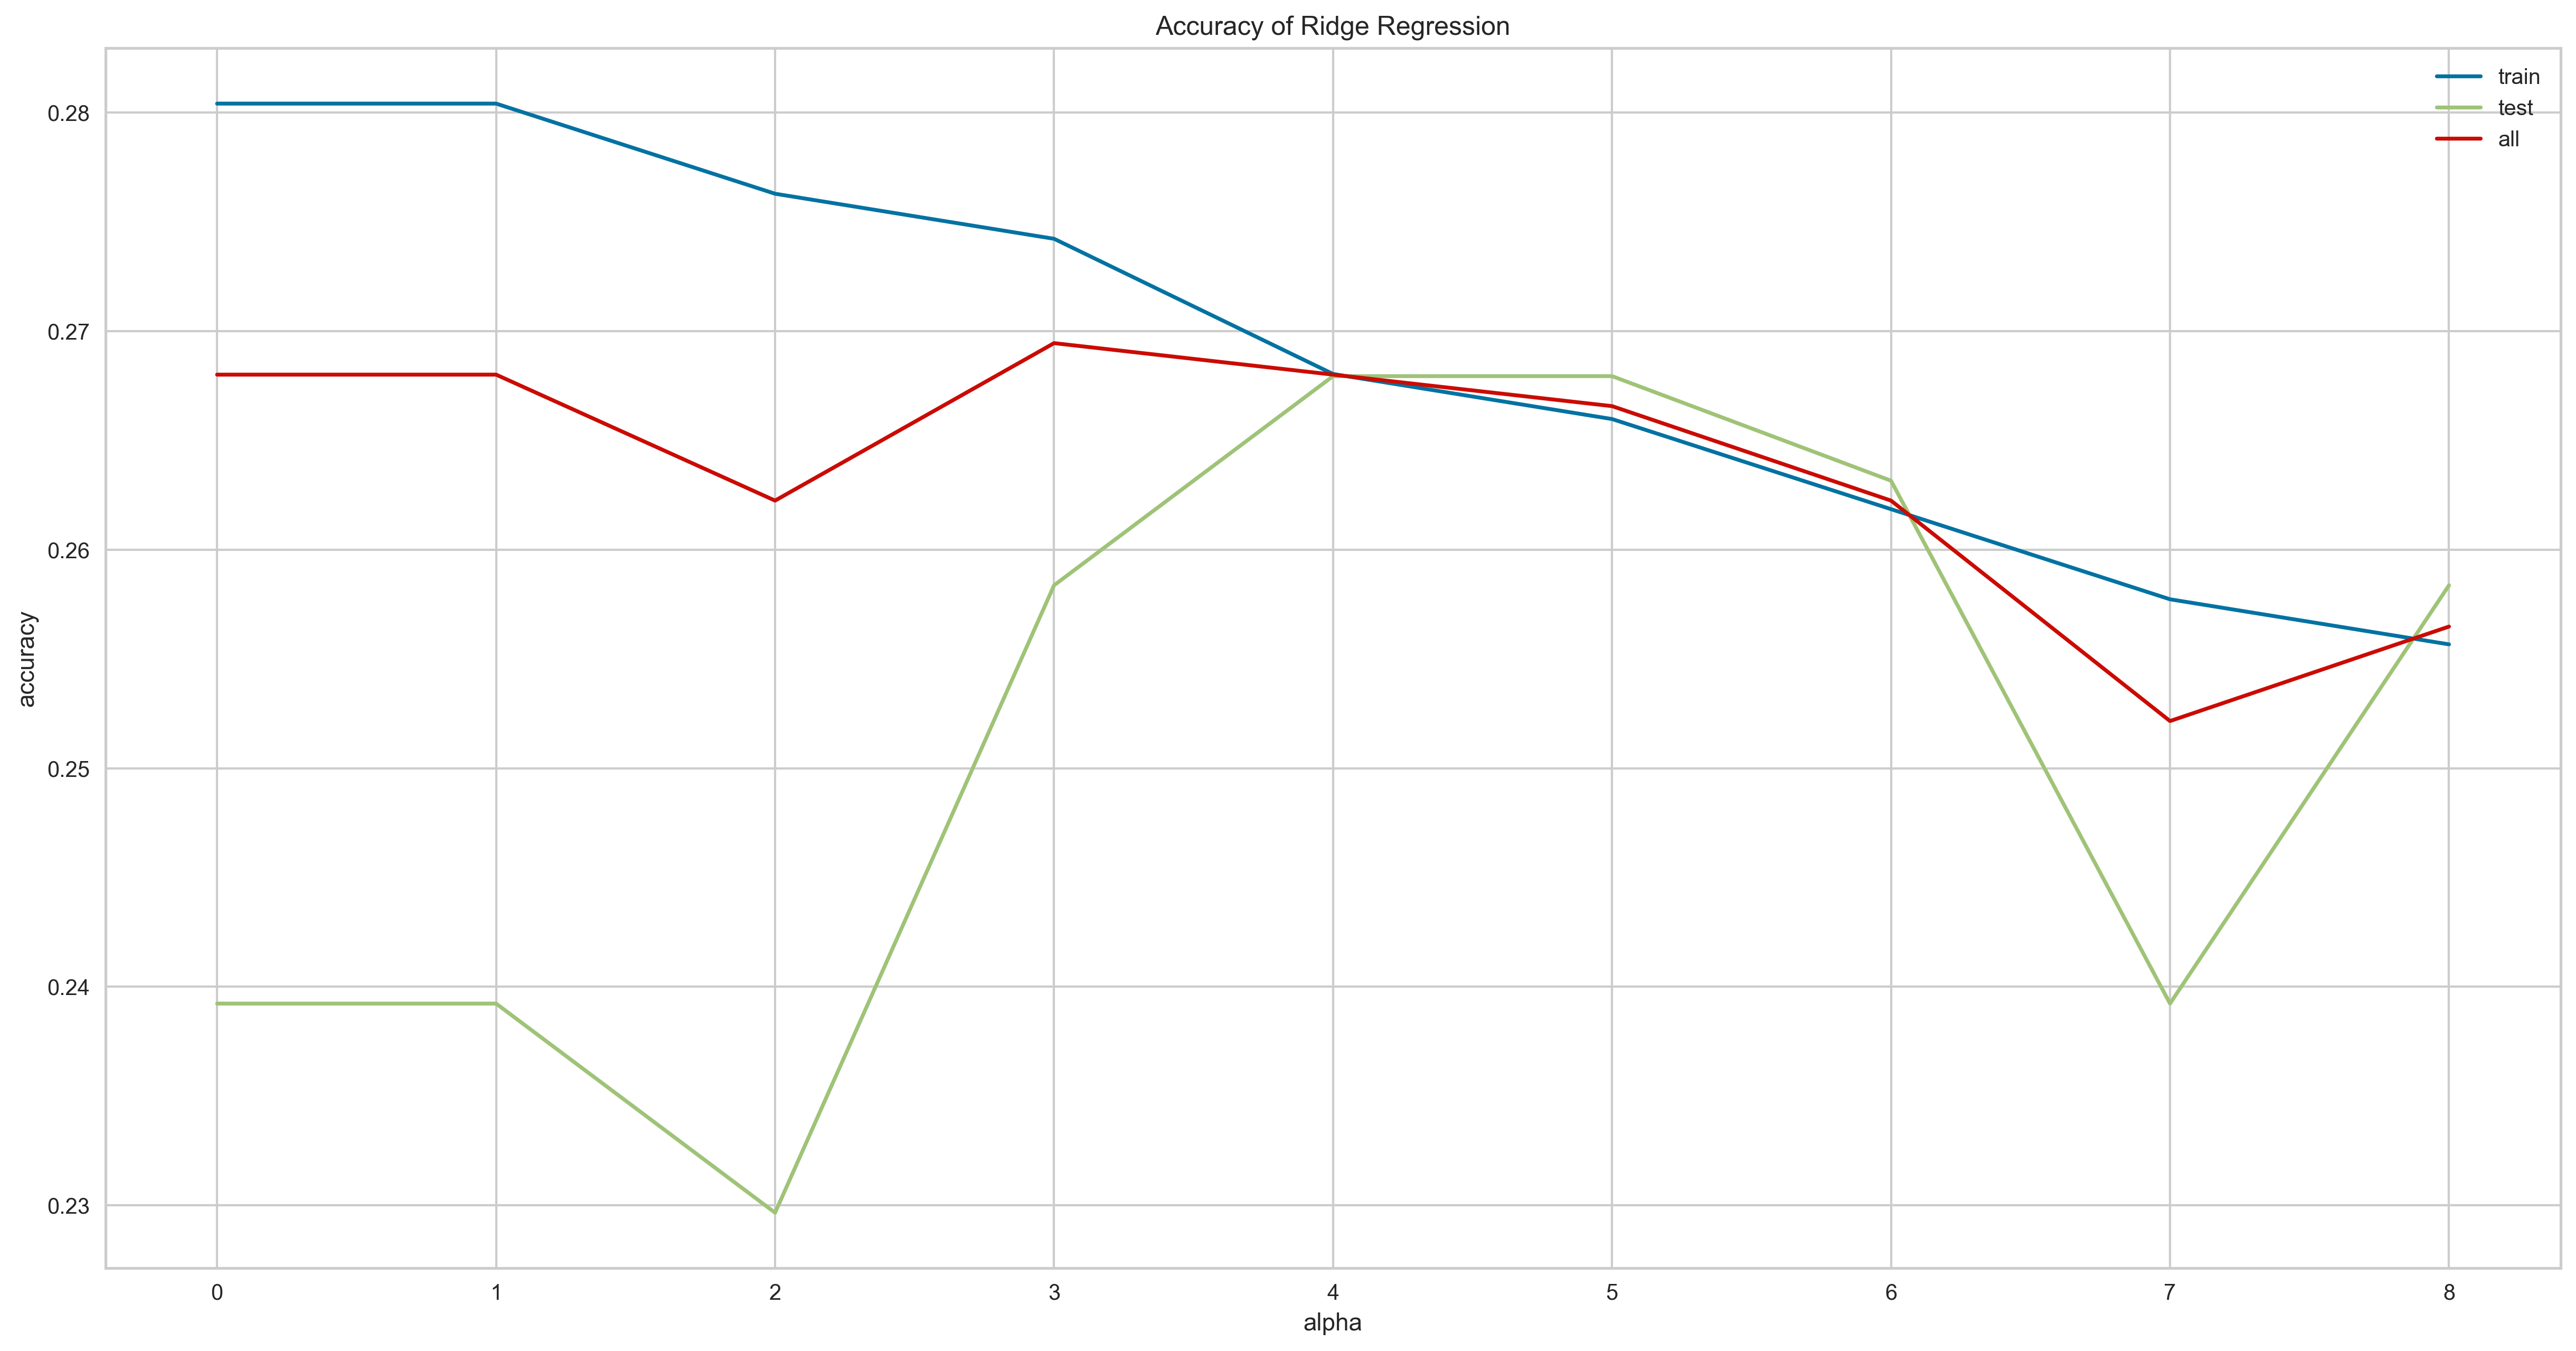

In [57]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
all_scores = [clf.score(X_data, y_data) for clf in clfs]

plt.figure(figsize=(20, 10), dpi=300)
plt.plot(train_scores, label='train')
plt.plot(test_scores, label='test')
plt.plot(all_scores, label='all')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Accuracy of Ridge Regression')
plt.legend()
plt.show()

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.20      0.31      0.25        54
        Food       0.00      0.00      0.00        31
    Grooming       0.30      0.60      0.40        50
   Lifestyle       0.11      0.07      0.09        41
    Medicine       0.00      0.00      0.00        22
        Toys       0.00      0.00      0.00        11

    accuracy                           0.24       209
   macro avg       0.10      0.16      0.12       209
weighted avg       0.15      0.24      0.18       209



In [59]:
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.26      1.00      0.41       124
        Food       0.00      0.00      0.00        71
    Grooming       0.00      0.00      0.00       117
   Lifestyle       0.00      0.00      0.00        94
    Medicine       0.00      0.00      0.00        53
        Toys       0.00      0.00      0.00        26

    accuracy                           0.26       485
   macro avg       0.04      0.17      0.07       485
weighted avg       0.07      0.26      0.10       485



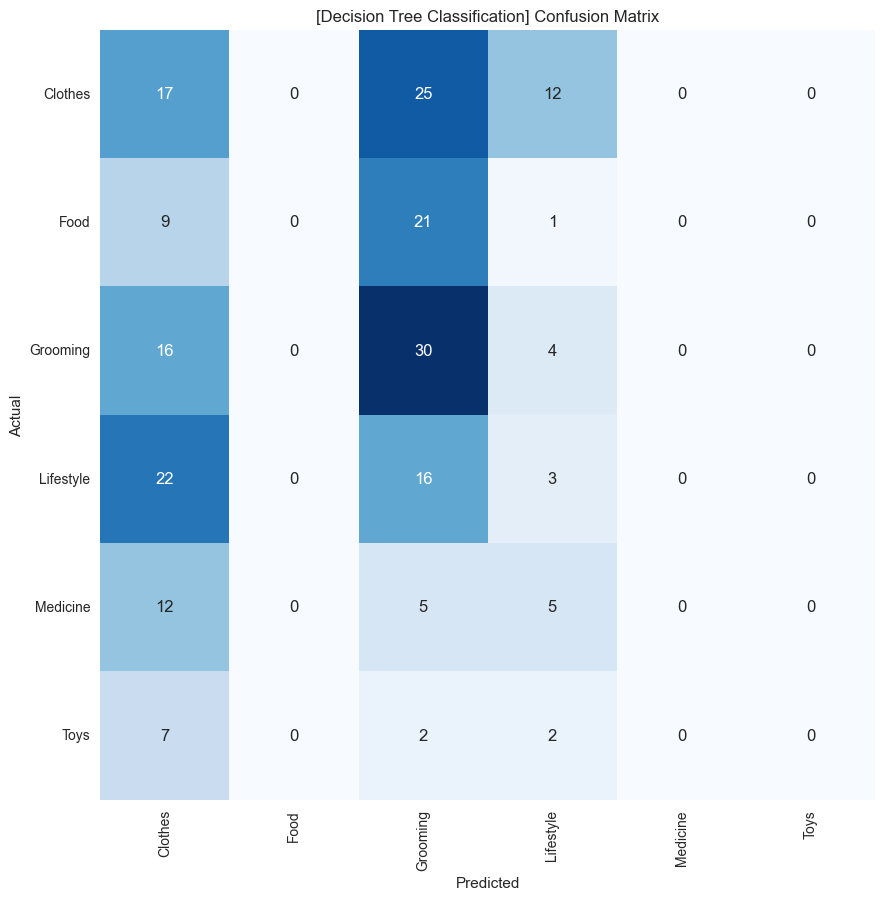

In [60]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('[Decision Tree Classification] Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

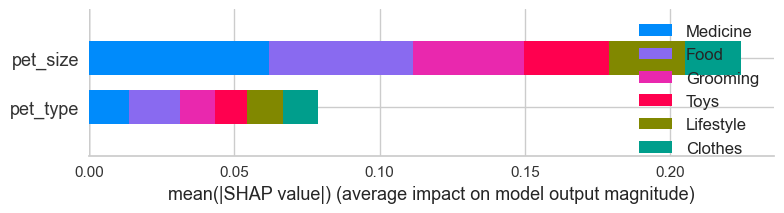

In [61]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Dummy Classifier

In [62]:
dummy_classifier = DummyClassifier(strategy="uniform", random_state=42)
dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Accuracy: 0.12440191387559808
Mean Squared Error: 6.181818181818182


In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.11      0.07      0.09        54
        Food       0.10      0.10      0.10        31
    Grooming       0.19      0.12      0.15        50
   Lifestyle       0.16      0.17      0.16        41
    Medicine       0.09      0.14      0.11        22
        Toys       0.09      0.27      0.13        11

    accuracy                           0.12       209
   macro avg       0.12      0.15      0.12       209
weighted avg       0.13      0.12      0.12       209



In [44]:
y_pred_train = dummy_classifier.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.22      0.16      0.19       124
        Food       0.14      0.14      0.14        71
    Grooming       0.22      0.15      0.18       117
   Lifestyle       0.18      0.18      0.18        94
    Medicine       0.08      0.11      0.10        53
        Toys       0.04      0.12      0.06        26

    accuracy                           0.15       485
   macro avg       0.15      0.14      0.14       485
weighted avg       0.18      0.15      0.16       485



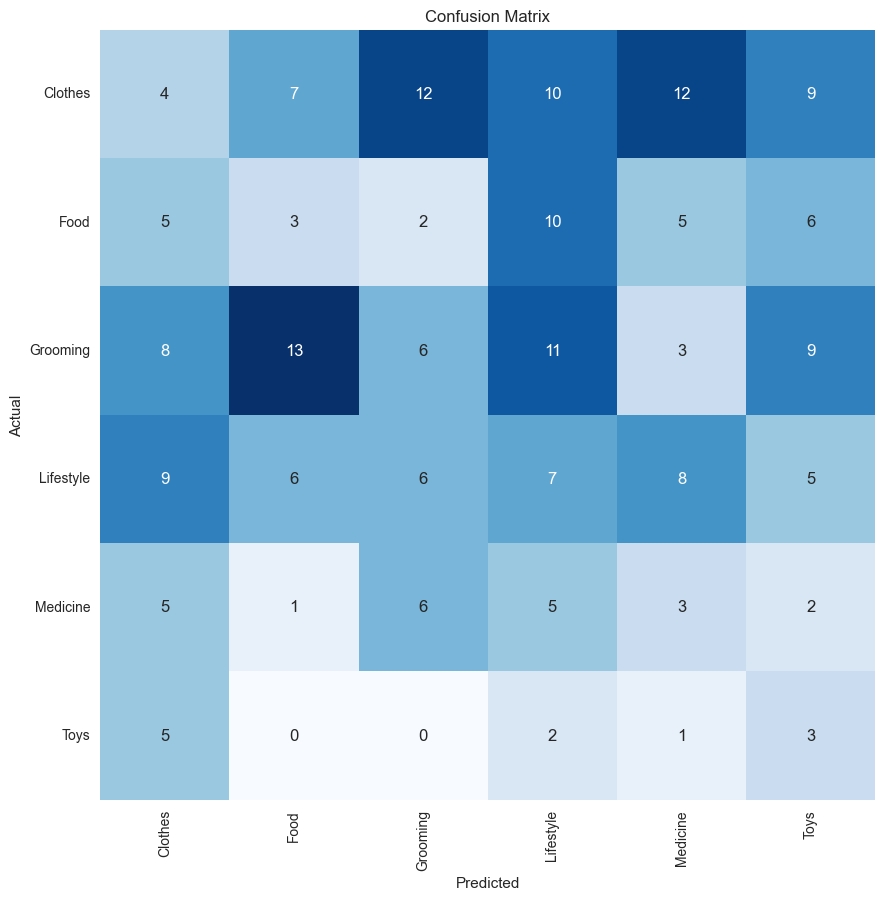

In [45]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

In [46]:
with open("./export/exported_dummy_classifier.pkl", "wb") as f:
    saved_model = pickle.dump(dummy_classifier, f)

# KNN in 3 dimension

In [47]:
knn = KNeighborsClassifier(n_neighbors=6, p=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='uniform')

In [48]:
y_pred = knn.predict(X_test)
print(f"Model score: {knn.score(X_test, y_test)}")

Model score: 0.215311004784689


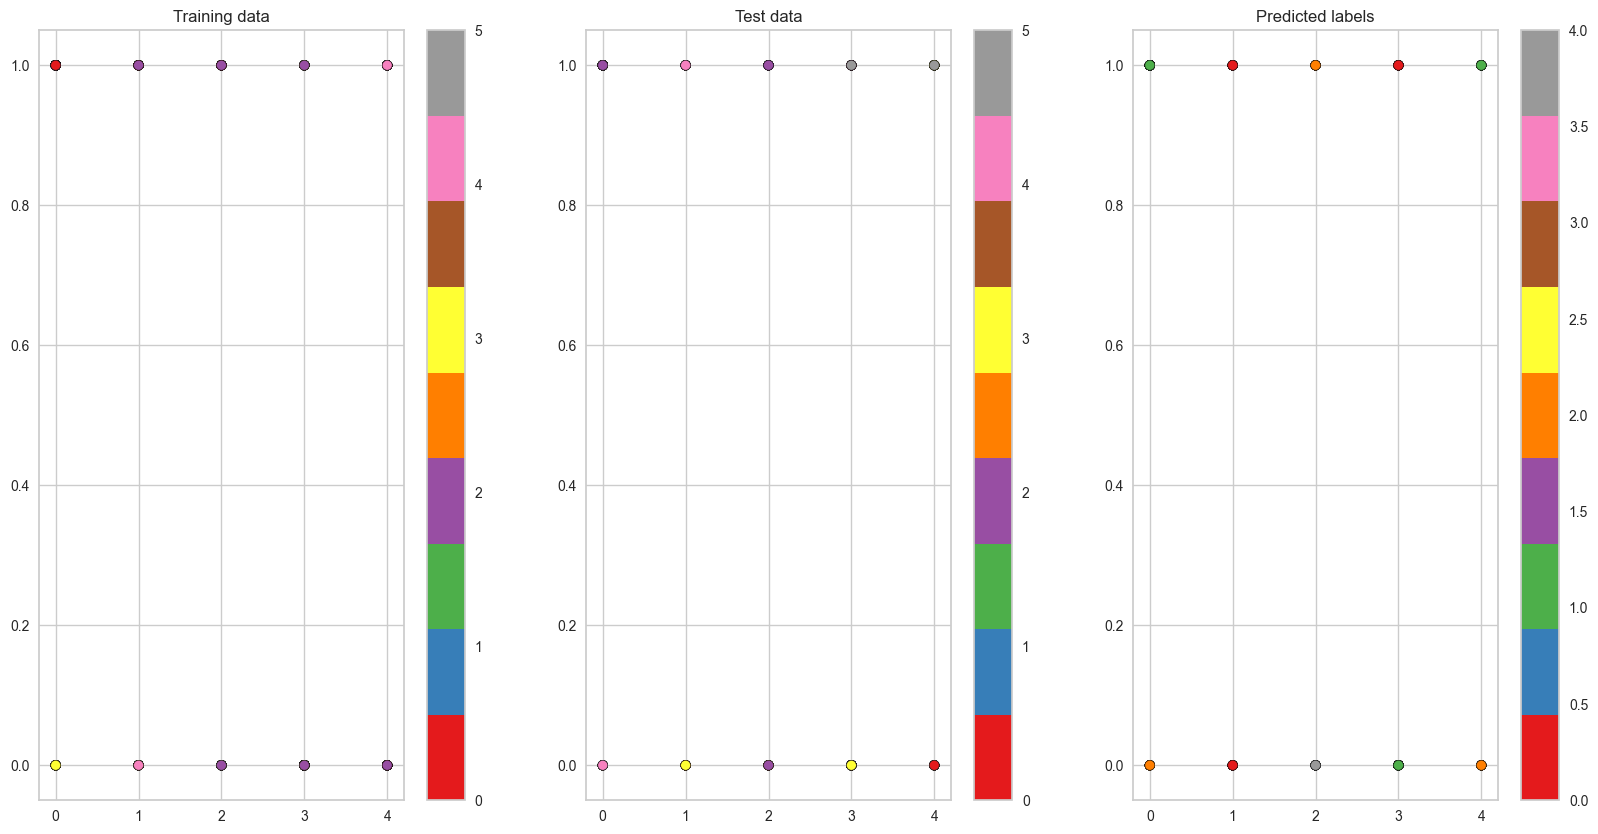

In [49]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title("Training data")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Test data")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Predicted labels")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.show()

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.30      0.24      0.27        54
        Food       0.19      0.71      0.30        31
    Grooming       0.24      0.18      0.21        50
   Lifestyle       0.00      0.00      0.00        41
    Medicine       0.08      0.05      0.06        22
        Toys       0.00      0.00      0.00        11

    accuracy                           0.22       209
   macro avg       0.13      0.20      0.14       209
weighted avg       0.17      0.22      0.17       209



In [51]:
y_pred_train = knn.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.25      0.18      0.21       124
        Food       0.20      0.76      0.32        71
    Grooming       0.19      0.15      0.17       117
   Lifestyle       0.00      0.00      0.00        94
    Medicine       0.19      0.11      0.14        53
        Toys       0.00      0.00      0.00        26

    accuracy                           0.21       485
   macro avg       0.14      0.20      0.14       485
weighted avg       0.16      0.21      0.16       485



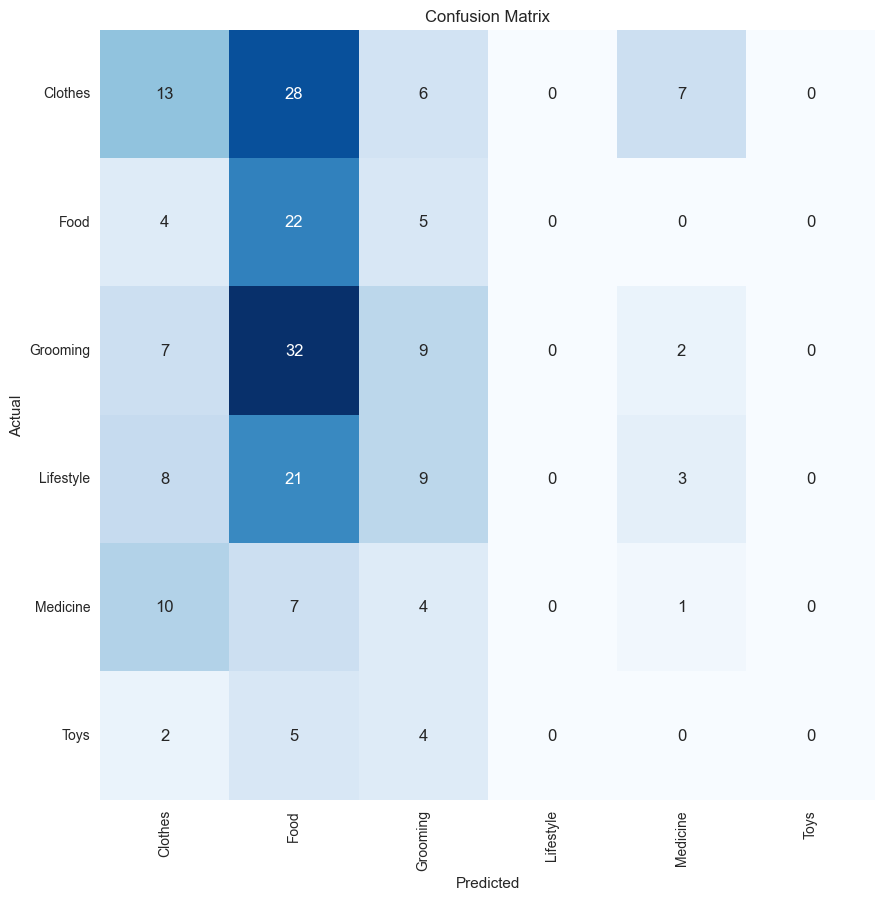

In [52]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()